In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [04:02<00:00, 20.64it/s]


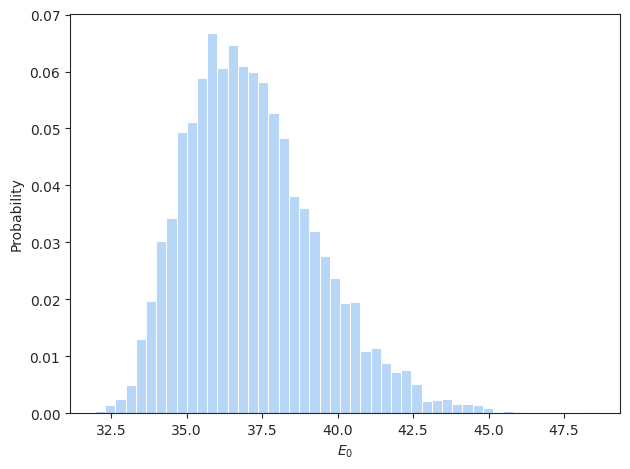

In [36]:
import numpy as np
from scipy.sparse.linalg import eigsh
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

from nonlocalgames.hamiltonians import G14

values = []
ham = G14(init_mode='normal')
for i in tqdm(range(5000)):
    ham.init(seed=i)
    w, _ = eigsh(ham.mat, k=1, which='LA')
    values.append(w.item())

sns.histplot(data=values, stat='probability')
plt.xlabel('$E_0$')
plt.tight_layout()
plt.savefig('plots/g14/g14_random_init.png', dpi=300)

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%%bash

# Run trials with multiprocessing
python examples/g14/run_g14.py \
    --num-cpus=4 \
    --seeds=data/seeds.txt
    -n 50

10418.16s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


2023-08-15 16:31:25,106	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
Starting processing
100%|███████████████████████████████████████████| 50/50 [21:37<00:00, 25.95s/it]
Postprocessing
Aggregating results


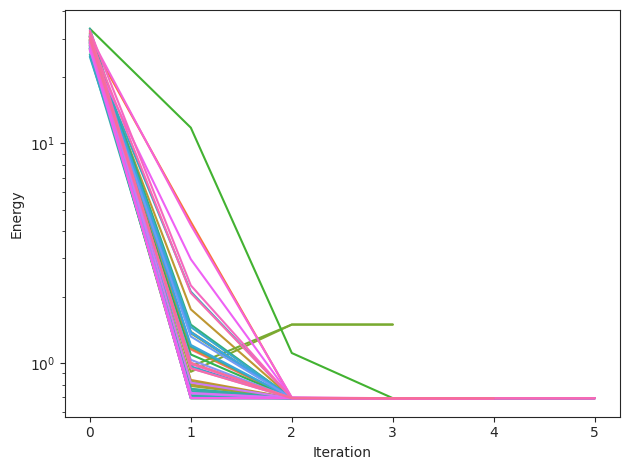

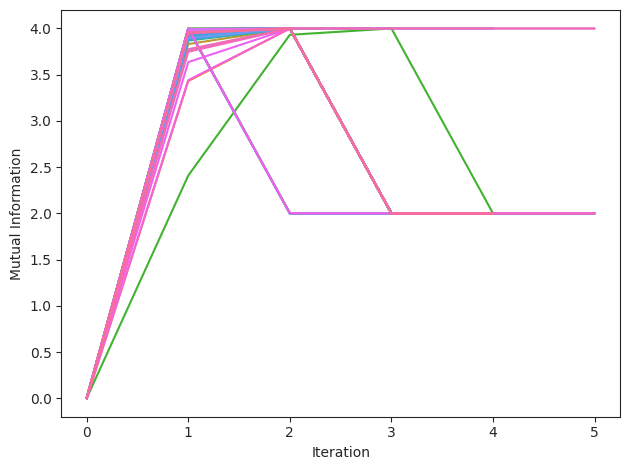

In [21]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

df = pd.read_csv('data/g14_trials.csv')
sns.lineplot(data=df, x='iter', y='energy', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/g14_trials.png', dpi=300)
plt.show()

sns.lineplot(data=df, x='iter', y='mutual_information', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.savefig('plots/g14_mutual_information.png', dpi=300)
plt.show()

### Test generated circuit

We're going to load the saved ADAPT ansatz and convert it to a Qiskit circuit. Then, we'll use the utility class `NLGCircuit` to evaluate each of the possible referee questions on G14.

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


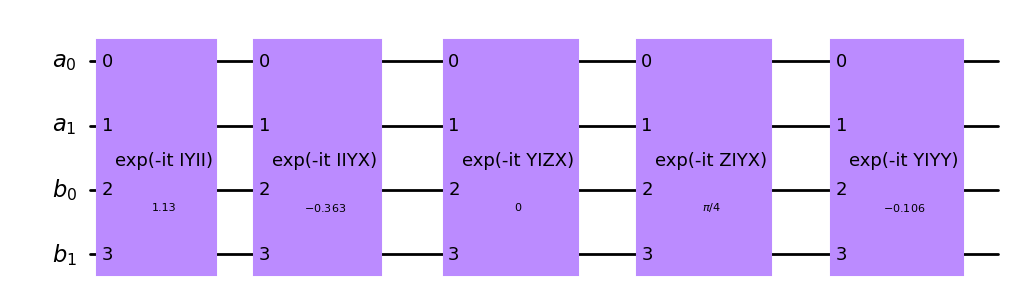

In [11]:
import json
import numpy as np

# Qiskit has deprecated code inside of it
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    from qiskit_aer import AerSimulator

    from nonlocalgames.hamiltonians import G14
    from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        [qubits] * players,
        adapt_order=False)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    return qc, phi

# Load best circuit
shared_state, phi = load_g14_circuit('data/g14_state.json')
shared_state.draw('mpl')

Construct the `NLGCircuit` from the ansatz, and draw it to make sure it looks reasonable.

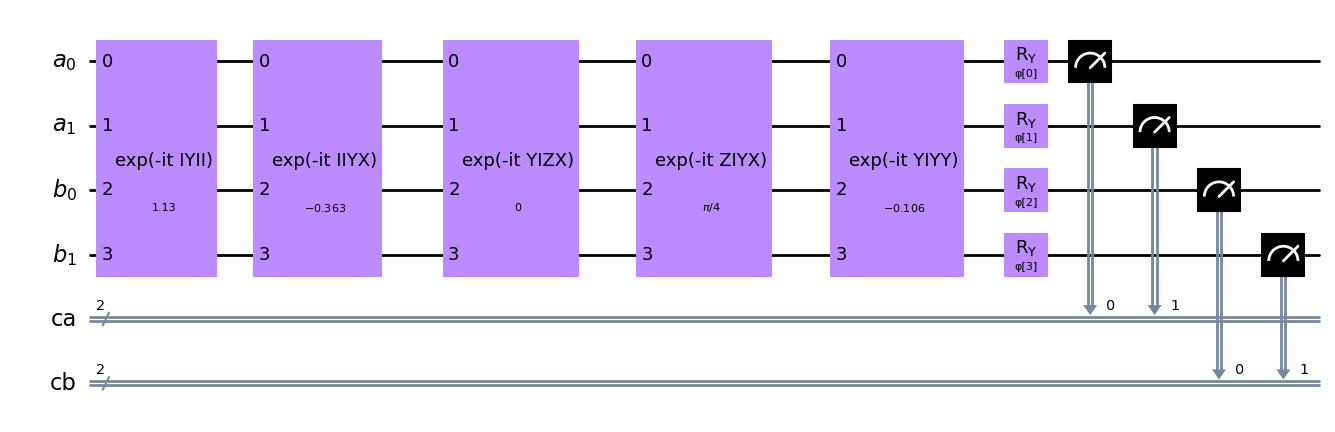

In [12]:
sim = AerSimulator()
nlg = NLGCircuit(shared_state, phi, sim=sim)
nlg.qc.draw('mpl')

Here's a sample response where $v_a = v_b = 1$. The players should respond with the same color $c_a = c_b$ to win.

In [13]:
nlg.ask([1, 1], shots=1024, seed_simulator=42)

{(2, 0): 2,
 (2, 3): 15,
 (1, 3): 193,
 (1, 0): 51,
 (3, 3): 97,
 (0, 3): 158,
 (0, 2): 69,
 (1, 1): 120,
 (1, 2): 114,
 (3, 2): 54,
 (3, 1): 34,
 (3, 0): 16,
 (0, 1): 75,
 (0, 0): 16,
 (2, 2): 10}

Construct a dataframe consisting of 1024 trials (shots) for each possible question.

In [14]:
import pandas as pd

vertices = [(i, i) for i in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges
N = 1024

records = []
for va, vb in questions:
    counts = nlg.ask((va, vb), shots=N, seed_simulator=42)
    for (ca, cb), n in counts.items():
        records.append({
            'va': va,
            'vb': vb,
            'ca': ca,
            'cb': cb,
            'n': n
        })

df = pd.DataFrame.from_records(records)
df.to_csv('data/g14_responses.csv', index=False)
df

,va,vb,ca,cb,n
0,0,0,2,2,1
1,0,0,3,1,468
2,0,0,3,0,39
3,0,0,3,2,20
4,0,0,2,3,12
...,...,...,...,...,...
1297,12,13,3,3,39
1298,12,13,1,0,126
1299,12,13,1,3,82
1300,12,13,1,2,225


We'd like to calculate the win rate for each question.

In [15]:
def winrate(gdf: pd.DataFrame):
    if np.all(gdf.va == gdf.vb):
        return gdf.loc[gdf.ca == gdf.cb].n.sum() / N
    else:
        return gdf.loc[gdf.ca != gdf.cb].n.sum() / N

wr = df.groupby(['va', 'vb']).apply(winrate).reset_index(name='win_rate')
wr

,va,vb,win_rate
0,0,0,0.216797
1,0,1,0.684570
2,0,2,0.808594
3,0,3,0.684570
4,0,4,0.817383
...,...,...,...
83,13,9,0.727539
84,13,10,0.666992
85,13,11,0.747070
86,13,12,0.844727


In [16]:
wr.to_csv('data/g14_win_rate.csv', index=False)

Plot the win rate per question type (either $v_a = v_b$ or $v_a \sim v_b$).

<>:6: DeprecationWarning: invalid escape sequence '\s'


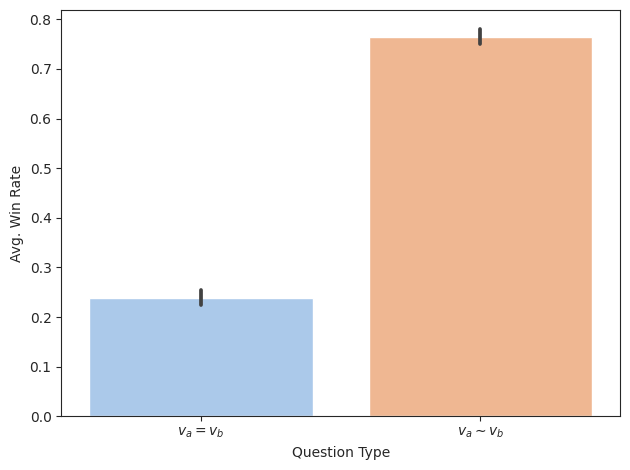

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('pastel')

wr['question'] = np.where(wr.va == wr.vb, r'$v_a = v_b$', r'$v_a \sim v_b$')

sns.barplot(data=wr, x='question', y='win_rate')
plt.xlabel('Question Type')
plt.ylabel('Avg. Win Rate')
plt.tight_layout()
plt.savefig('plots/g14/g14_win_rate.png', dpi=300)
plt.show()

Calculate the balance of the question types. The fact that there's many more edge questions than vertex questions suggests we should re-weight the hamiltonian terms, similar to if we had an imbalanced dataset in a supervised learning problem.

In [18]:
print(wr.question.value_counts())

$v_a \sim v_b$    74
$v_a = v_b$       14
Name: question, dtype: int64


### G14 Balanced

In [72]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
%%bash

# Run trials with multiprocessing
python examples/g14/run_g14.py \
    --num-cpus=4 \
    --seeds=data/seeds.txt \
    -n 50 \
    --weighting=balanced

2023-08-16 10:25:15,736	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


Starting processing
Error while terminating subprocess (pid=24897): 


In [ ]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
sns.set_style('ticks')

df = pd.read_csv('data/g14_trials.csv')
sns.lineplot(data=df, x='iter', y='energy', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.yscale('log')
plt.tight_layout()
plt.savefig('plots/g14_trials.png', dpi=300)
plt.show()

sns.lineplot(data=df, x='iter', y='mutual_information', hue=df.seed.astype(str), legend=False)
plt.xlabel('Iteration')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.savefig('plots/g14_mutual_information.png', dpi=300)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'data/g14_trials.csv'

In [ ]:
%load_ext autoreload
%autoreload 2

import json
import numpy as np

# Qiskit has deprecated code inside of it
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    from qiskit_aer import AerSimulator

    from nonlocalgames.hamiltonians import G14
    from nonlocalgames.circuit import NLGCircuit, load_adapt_ansatz

def load_g14_circuit(path: str):
    with open(path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    qubits = 2
    players = 2
    qc = load_adapt_ansatz(
        data['state'],
        [qubits] * players,
        adapt_order=False)

    # Don't need to transform phi since qinfo's Ry gate follows the qiskit convention
    phi = np.array(data['phi'])

    return qc, phi

# Load best circuit
shared_state, phi = load_g14_circuit('data/g14_state.json')
shared_state.draw('mpl')

In [ ]:
sim = AerSimulator()
nlg = NLGCircuit(shared_state, phi, sim=sim)
nlg.qc.draw('mpl')

In [ ]:
import pandas as pd

vertices = [(i, i) for i in range(14)]
edges = G14._get_graph().edge_links.tolist()
questions = vertices + edges
N = 1024

records = []
for va, vb in questions:
    counts = nlg.ask((va, vb), shots=N, seed_simulator=42)
    for (ca, cb), n in counts.items():
        records.append({
            'va': va,
            'vb': vb,
            'ca': ca,
            'cb': cb,
            'n': n
        })

df = pd.DataFrame.from_records(records)
df.to_csv('data/g14_responses.csv', index=False)
df

In [ ]:
def winrate(gdf: pd.DataFrame):
    if np.all(gdf.va == gdf.vb):
        return gdf.loc[gdf.ca == gdf.cb].n.sum() / N
    else:
        return gdf.loc[gdf.ca != gdf.cb].n.sum() / N

wr = df.groupby(['va', 'vb']).apply(winrate).reset_index(name='win_rate')
wr.to_csv('data/g14_win_rate.csv', index=False)
wr

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')
sns.set_palette('pastel')

wr['question'] = np.where(wr.va == wr.vb, r'$v_a = v_b$', r'$v_a \sim v_b$')

sns.barplot(data=wr, x='question', y='win_rate')
plt.xlabel('Question Type')
plt.ylabel('Avg. Win Rate')
plt.tight_layout()
plt.savefig('plots/g14/g14_win_rate.png', dpi=300)
plt.show()